In [1]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import xgboost as xgb

xgb.set_config(verbosity=0)
import joblib
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("../../emotion_classifier/model_training/models/bandai_l2p_model.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("../../emotion_classifier/model_training/models/bandai_l2a_model.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("../../emotion_classifier/model_training/models/bandai_l2d_model.json")

scaler = joblib.load('../../emotion_classifier/model_training/datasets/scalers/standardizers/S_BANDAI_5frame.pkl') 

In [3]:
dataset = pd.read_csv('datasets/BANDAI_5frame.csv')
dataset.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude,EMOTION_P,EMOTION_A,EMOTION_D
0,0.433596,0.158604,0.262368,0.538619,0.204290,0.286321,0.174445,0.107800,0.236151,0.223894,...,0.544719,0.747464,0.783573,2.388999,2.320488,1.089438,1.494928,0.05,-0.4,0.0
1,0.502380,0.348371,0.141433,0.355769,0.308451,0.226158,0.114087,0.185519,0.236151,0.223894,...,0.375438,0.813410,1.279194,1.685722,0.708942,0.661071,0.783065,0.05,-0.4,0.0
2,0.523859,0.430275,0.176769,0.588712,0.337860,0.209359,0.111133,0.249847,0.236151,0.223894,...,0.343913,0.897555,0.762036,0.337886,0.417700,0.325002,0.209341,0.05,-0.4,0.0
3,0.506404,0.372590,0.182689,0.671607,0.304908,0.199841,0.092428,0.244035,0.236151,0.223894,...,1.118295,0.912977,1.376315,0.773128,0.324001,1.594570,0.748233,0.05,-0.4,0.0
4,0.399879,0.189986,0.280258,0.595205,0.236768,0.250473,0.108253,0.145548,0.236151,0.223894,...,1.306542,0.828419,0.436481,0.562979,1.256880,0.433401,0.184292,0.05,-0.4,0.0


In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 20829
No Test Samples: 5207


In [5]:
train_emotions = pd.concat([train_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
train_emotions_OG = train_emotions.copy()

test_emotions = pd.concat([test_dataset.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_emotions_OG = test_emotions.copy()

In [6]:
scaled_train = scaler.transform(train_dataset.copy())

train_emotions_p = model_p.predict(scaled_train)
train_emotions_a = model_a.predict(scaled_train)
train_emotions_d = model_d.predict(scaled_train)

rows = []
for i in range(len(train_dataset)):
    rows.append([train_emotions_p[i], train_emotions_a[i], train_emotions_d[i]])

train_emotions = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

train_emotions.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,0.050712,-0.417300,-0.009472
1,0.599043,0.398057,0.102201
2,0.107264,0.602972,0.422206
3,0.297911,0.401080,0.594318
4,0.299707,0.399537,0.600845


In [7]:
train_emotions_OG.head()

,EMOTION_P,EMOTION_A,EMOTION_D
14196,0.05,-0.4,0.0
21866,0.60,0.4,0.1
13202,0.10,0.6,0.4
18185,0.30,0.4,0.6
8423,0.30,0.4,0.6


In [8]:
# Remove LMA features whose predictions are too different from the real one
index_for_removal = []
for ind in train_emotions.index:
    predicted = np.asarray([train_emotions.iloc[ind]])
    true = np.asarray([train_emotions_OG.iloc[ind]])
    
    #print(predicted)
    #print(true)
    
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.2 or mae_errors[1] > 0.2 or mae_errors[2] > 0.2):
        index_for_removal.append(ind)
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.11):
        index_for_removal.append(ind)
        continue
    
    #print()

#print(index_for_removal)


In [9]:
train_emotions_OG.drop(train_emotions_OG.index[index_for_removal], inplace=True)
print(train_emotions_OG.shape)
train_emotions_OG.head()

(20826, 3)


,EMOTION_P,EMOTION_A,EMOTION_D
14196,0.05,-0.4,0.0
21866,0.60,0.4,0.1
13202,0.10,0.6,0.4
18185,0.30,0.4,0.6
8423,0.30,0.4,0.6


In [10]:
train_emotions.drop(train_emotions.index[index_for_removal], inplace=True)
print(train_emotions.shape)
train_emotions.head()

(20826, 3)


,EMOTION_P,EMOTION_A,EMOTION_D
0,0.050712,-0.417300,-0.009472
1,0.599043,0.398057,0.102201
2,0.107264,0.602972,0.422206
3,0.297911,0.401080,0.594318
4,0.299707,0.399537,0.600845


In [11]:
train_dataset.drop(train_dataset.index[index_for_removal], inplace=True)
print(train_dataset.shape)
train_dataset.head()

(20826, 25)


,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
14196,0.591840,0.318827,0.274210,0.362782,0.412513,0.382210,0.265800,0.231608,0.236151,0.223894,...,0.247334,0.637878,0.712397,0.225389,0.402203,0.265700,0.231319,0.256906,0.233661,0.145566
21866,0.645409,0.355432,0.220538,0.472060,0.367919,0.253580,0.210580,0.080716,0.236151,0.223894,...,1.262705,0.856128,0.465088,1.147179,0.944418,0.713628,0.945653,0.188661,0.417395,0.186159
13202,0.736681,0.354510,0.340797,0.652112,0.321380,0.402189,0.306916,0.331583,0.236151,0.223894,...,1.982262,1.032810,0.860925,1.959347,1.454995,1.398855,1.776646,0.913462,0.651474,0.487055
18185,0.936586,0.501873,0.447656,0.365920,0.508060,0.437086,0.399077,0.354849,0.236151,0.223894,...,1.068575,1.338377,1.293100,0.723079,1.141735,1.472370,1.297093,0.413352,0.872912,1.143437
8423,0.749651,0.330273,0.439349,0.723301,0.325838,0.440154,0.371883,0.386490,0.236151,0.223894,...,1.009285,1.180791,1.021084,1.222069,1.068320,0.827870,1.177343,0.702020,0.340237,0.780032


In [12]:
scaled_test = scaler.transform(test_dataset.copy())

test_emotions_p = model_p.predict(scaled_test)
test_emotions_a = model_a.predict(scaled_test)
test_emotions_d = model_d.predict(scaled_test)

rows = []
for i in range(len(test_dataset)):
    rows.append([test_emotions_p[i], test_emotions_a[i], test_emotions_d[i]])

test_emotions = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

test_emotions.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,0.061313,-0.375888,0.038967
1,0.151001,-0.575055,-0.218546
2,0.164378,0.523402,0.399045
3,0.109913,-0.675567,-0.216043
4,0.300064,0.403973,0.603667


In [13]:
test_emotions_OG.head()

,EMOTION_P,EMOTION_A,EMOTION_D
16843,0.05,-0.40,0.0
4997,0.20,-0.75,-0.3
2159,0.10,0.60,0.4
2424,0.15,-0.70,-0.2
17649,0.30,0.40,0.6


In [14]:
# Remove LMA features whose predictions are too different from the real one
index_for_removal = []
for ind in test_emotions.index:
    predicted = np.asarray([test_emotions.iloc[ind]])
    true = np.asarray([test_emotions_OG.iloc[ind]])
    
    #print(predicted)
    #print(true)
    
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.2 or mae_errors[1] > 0.2 or mae_errors[2] > 0.2):
        index_for_removal.append(ind)
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.11):
        index_for_removal.append(ind)
        continue
    
    #print()

#print(index_for_removal)


In [15]:
test_emotions_OG.drop(test_emotions_OG.index[index_for_removal], inplace=True)
print(test_emotions_OG.shape)
test_emotions_OG.head()

(4396, 3)


,EMOTION_P,EMOTION_A,EMOTION_D
16843,0.05,-0.40,0.0
4997,0.20,-0.75,-0.3
2159,0.10,0.60,0.4
2424,0.15,-0.70,-0.2
17649,0.30,0.40,0.6


In [16]:
test_emotions.drop(test_emotions.index[index_for_removal], inplace=True)
print(test_emotions.shape)
test_emotions.head()

(4396, 3)


,EMOTION_P,EMOTION_A,EMOTION_D
0,0.061313,-0.375888,0.038967
1,0.151001,-0.575055,-0.218546
2,0.164378,0.523402,0.399045
3,0.109913,-0.675567,-0.216043
4,0.300064,0.403973,0.603667


In [17]:
test_dataset.drop(test_dataset.index[index_for_removal], inplace=True)
print(test_dataset.shape)
test_dataset.head()

(4396, 25)


,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
16843,0.412864,0.311887,0.215825,0.551596,0.261448,0.250320,0.103413,0.134163,0.236151,0.223894,...,0.835546,1.268002,1.479542,0.638237,1.030965,0.945892,1.039950,0.596542,0.930864,0.604149
4997,0.474571,0.184169,0.453603,0.557230,0.105773,0.360121,0.248461,0.120591,0.236151,0.223894,...,1.111145,1.041321,0.578671,1.350240,1.064601,0.316814,0.671274,0.577996,0.464118,0.169529
2159,0.585772,0.276237,0.400224,0.897598,0.255654,0.370538,0.217619,0.122665,0.236151,0.223894,...,1.307202,1.468693,1.241878,1.912422,1.374853,1.032378,1.634662,0.844460,0.951111,0.950998
2424,0.519494,0.244179,0.270064,0.471464,0.368603,0.376937,0.238238,0.258272,0.236151,0.223894,...,0.616039,0.353955,0.294531,0.623217,0.393225,0.304760,0.220321,0.202995,0.224186,0.245866
17649,0.828004,0.430178,0.380527,0.720045,0.433213,0.439793,0.363835,0.311532,0.236151,0.223894,...,0.455164,0.714867,0.774444,0.363253,0.572622,0.285750,0.157889,0.589683,0.319100,0.322917



# AutoEncoder


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [19]:
"""
self.encoder = tf.keras.Sequential([
            layers.Dense(20, activation='relu'),
            layers.Dense(15, activation='linear'),
            layers.Dense(10, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(10, activation='relu'),
            layers.Dense(15, activation='linear'),
            layers.Dense(20, activation='relu'),
            layers.Dense(25, activation='linear'),
        ])
epochs = 128
"""

latent_dim = 5

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(20, activation='relu'),
            layers.Dense(15, activation='linear'),
            layers.Dense(10, activation='relu'),
            layers.Dense(latent_dim, activation='linear'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(10, activation='relu'),
            layers.Dense(15, activation='linear'),
            layers.Dense(20, activation='relu'),
            layers.Dense(25, activation='linear'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

## Train

In [20]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [21]:
autoencoder.fit(train_dataset, train_dataset,
                epochs=256,
                shuffle=True,
                validation_data=(test_dataset, test_dataset))

Epoch 1/256
651/651 [==============================] - 2s 2ms/step - loss: 0.0388 - val_loss: 0.0154
Epoch 2/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0121
Epoch 3/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0117
Epoch 4/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0084
Epoch 5/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 6/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 7/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 8/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 9/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 10/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0071 - val_lo

Epoch 161/256
651/651 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 162/256
651/651 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 163/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 164/256
651/651 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 165/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 166/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 167/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 168/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 169/256
651/651 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 170/256
651/651 [==============================] - 1s 1ms/step - lo

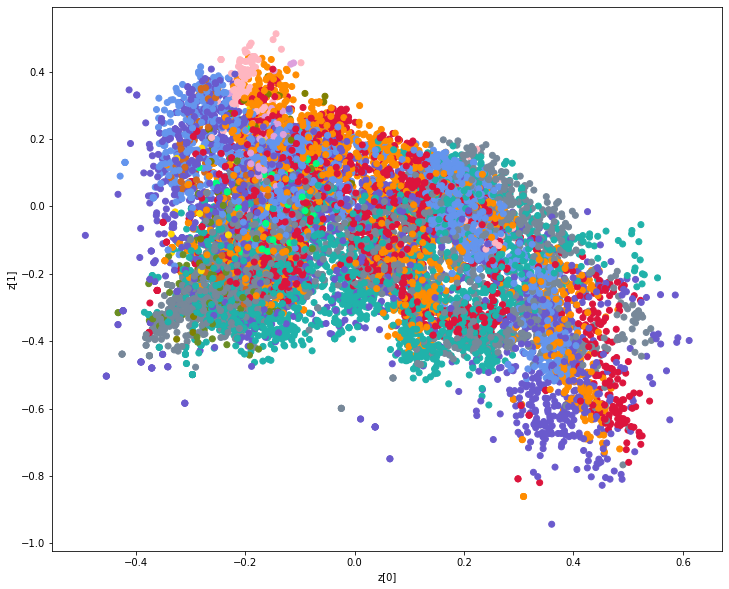

In [26]:
conv_dict = {
    (0.05, -0.4, 0.0): "neutral",
    (0.15, -0.7, -0.2): "tired",
    (-0.1, -0.55, -0.15): "exhausted",
    (0.2, -0.75, -0.3): "exhausted_2",
    (-0.5, 0.8, 0.9): "angry",
    (0.8, 0.5, 0.15): "happy",
    (0.6, 0.4, 0.1): "happy_2",
    (-0.6, -0.4, -0.3): "sad",
    (0.4, 0.2, 0.3): "proud", 
    (0.3, 0.3, 0.9): "confident", 
    (0.25, 0.15, 0.3): "confident_2",
    (0.25, 0.15, 0.3): "confident_3",
    (0.3, 0.4, 0.6): "confident_4", 
    (-0.6, 0.7, -0.8): "afraid",
    (0.1, 0.6, 0.4): "active", 
}

colour_dict = {
    "neutral": "crimson",
    "tired": "springgreen",
    "exhausted": "cornflowerblue",
    "exhausted_2": "darkorange"  ,
    "angry": "gold",
    "happy": "olive",
    "happy_2": "lightseagreen",
    "sad": "plum",
    "proud": "chocolate",
    "confident": "olivedrab",
    "confident_2": "purple",
    "confident_4": "lightslategray",
    "afraid": "lightpink", 
    "active": "slateblue", 
}

def plot_label_clusters(autoencoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    encoded = autoencoder.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    
    actual_labels = []
    for i in range(len(labels)):
        point_coords = (labels.iloc[i][0], labels.iloc[i][1], labels.iloc[i][2])

        actual_labels.append(colour_dict[conv_dict[point_coords]])

    
    plt.scatter(encoded[:, 0], encoded[:, 1], c=actual_labels)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(autoencoder, test_dataset, test_emotions_OG)


In [22]:
index = 1

sample = np.asarray(test_dataset.iloc[index])
sample = sample.reshape(1,-1)
print(sample)

actual_coords = np.asarray(test_emotions_OG.iloc[index])

[[0.47457099 0.18416855 0.45360326 0.55723015 0.10577287 0.36012121
  0.24846099 0.12059073 0.23615103 0.223894   0.32519757 0.09487482
  0.08471979 0.05928083 0.13804531 1.11114517 1.04132085 0.57867091
  1.35024041 1.06460135 0.31681408 0.67127431 0.5779958  0.46411784
  0.16952929]]


In [23]:
generated = autoencoder.encoder.predict(sample)
print(generated)

[[-1.0032239   1.1770763  -0.17650734  0.46055943 -0.01859276]]


In [24]:
regen = autoencoder.decoder.predict(generated)
print(regen)

[[0.46283978 0.24777803 0.322452   0.5654528  0.21931422 0.29733676
  0.2007765  0.21566218 0.23614539 0.22393158 0.31102005 0.07833186
  0.09646311 0.05715787 0.14539239 1.180707   0.9345561  0.6973109
  1.3630222  1.0220402  0.4008718  0.5993937  0.610056   0.38709846
  0.18434921]]


In [25]:
scaled_sample = scaler.transform(sample)

real_coordinates = (
    model_p.predict(scaled_sample),
    model_a.predict(scaled_sample),
    model_d.predict(scaled_sample)
)

scaled_regen = scaler.transform(regen)

generated_coordinates = (
    model_p.predict(scaled_regen),
    model_a.predict(scaled_regen),
    model_d.predict(scaled_regen)
)


print('Real: %s' % np.asarray(actual_coords))
print('Predicted: %s' % np.asarray(real_coordinates).transpose()[0])
print('Generated: %s' % np.asarray(generated_coordinates).transpose()[0])

Real: [ 0.2  -0.75 -0.3 ]
Predicted: [ 0.15100127 -0.57505506 -0.21854573]
Generated: [ 0.21825778 -0.5029772  -0.13809268]


/home/diogosilva/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/home/diogosilva/.local/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


### Save Model

In [31]:
autoencoder.save("models/bandai/ae/autoencoder_5")

INFO:tensorflow:Assets written to: models/bandai/ae/autoencoder_5/assets



# PAD - Latent Space 

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [27]:
generated_train = autoencoder.encoder.predict(train_dataset)
generated_test = autoencoder.encoder.predict(test_dataset)

generated_train_x = train_emotions.copy()
generated_test_x = test_emotions.copy()
#generated_train_x = train_emotions_OG.copy()
#generated_test_x = test_emotions_OG.copy()

In [28]:
# Remove LMA features whose predictions are too different from the real one
generated_decoded_train = autoencoder.decoder.predict(generated_train)

index_for_removal = []
scaled_sample = scaler.transform(sample)


for ind in range(0,generated_decoded_train.shape[0]):
    print(str(ind) + " / " + str(generated_decoded_train.shape[0]))
    
    predicted = np.asarray([generated_decoded_train[ind]])
    true = np.asarray([train_emotions.iloc[ind]])

    predicted = scaler.transform(predicted)

    predicted = (
        model_p.predict(predicted),
        model_a.predict(predicted),
        model_d.predict(predicted)
    )
    
    predicted = np.asarray(predicted).transpose()
    
    #print(predicted)
    #print(true)
    
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.25 or mae_errors[1] > 0.25 or mae_errors[2] > 0.25):
        index_for_removal.append(ind)
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.15):
        index_for_removal.append(ind)
        continue
    
    #print()

print(len(index_for_removal))


0 / 20826
1 / 20826
2 / 20826
3 / 20826
4 / 20826
5 / 20826
6 / 20826
7 / 20826
8 / 20826
9 / 20826
10 / 20826
11 / 20826
12 / 20826
13 / 20826
14 / 20826
15 / 20826
16 / 20826
17 / 20826
18 / 20826
19 / 20826
20 / 20826
21 / 20826
22 / 20826
23 / 20826
24 / 20826
25 / 20826
26 / 20826
27 / 20826
28 / 20826
29 / 20826
30 / 20826
31 / 20826
32 / 20826
33 / 20826
34 / 20826
35 / 20826
36 / 20826
37 / 20826
38 / 20826
39 / 20826
40 / 20826
41 / 20826
42 / 20826
43 / 20826
44 / 20826
45 / 20826
46 / 20826
47 / 20826
48 / 20826
49 / 20826
50 / 20826
51 / 20826
52 / 20826
53 / 20826
54 / 20826
55 / 20826
56 / 20826
57 / 20826
58 / 20826
59 / 20826
60 / 20826
61 / 20826
62 / 20826
63 / 20826
64 / 20826
65 / 20826
66 / 20826
67 / 20826
68 / 20826
69 / 20826
70 / 20826
71 / 20826
72 / 20826
73 / 20826
74 / 20826
75 / 20826
76 / 20826
77 / 20826
78 / 20826
79 / 20826
80 / 20826
81 / 20826
82 / 20826
83 / 20826
84 / 20826
85 / 20826
86 / 20826
87 / 20826
88 / 20826
89 / 20826
90 / 20826
91 / 2082

704 / 20826
705 / 20826
706 / 20826
707 / 20826
708 / 20826
709 / 20826
710 / 20826
711 / 20826
712 / 20826
713 / 20826
714 / 20826
715 / 20826
716 / 20826
717 / 20826
718 / 20826
719 / 20826
720 / 20826
721 / 20826
722 / 20826
723 / 20826
724 / 20826
725 / 20826
726 / 20826
727 / 20826
728 / 20826
729 / 20826
730 / 20826
731 / 20826
732 / 20826
733 / 20826
734 / 20826
735 / 20826
736 / 20826
737 / 20826
738 / 20826
739 / 20826
740 / 20826
741 / 20826
742 / 20826
743 / 20826
744 / 20826
745 / 20826
746 / 20826
747 / 20826
748 / 20826
749 / 20826
750 / 20826
751 / 20826
752 / 20826
753 / 20826
754 / 20826
755 / 20826
756 / 20826
757 / 20826
758 / 20826
759 / 20826
760 / 20826
761 / 20826
762 / 20826
763 / 20826
764 / 20826
765 / 20826
766 / 20826
767 / 20826
768 / 20826
769 / 20826
770 / 20826
771 / 20826
772 / 20826
773 / 20826
774 / 20826
775 / 20826
776 / 20826
777 / 20826
778 / 20826
779 / 20826
780 / 20826
781 / 20826
782 / 20826
783 / 20826
784 / 20826
785 / 20826
786 / 20826
787 

1358 / 20826
1359 / 20826
1360 / 20826
1361 / 20826
1362 / 20826
1363 / 20826
1364 / 20826
1365 / 20826
1366 / 20826
1367 / 20826
1368 / 20826
1369 / 20826
1370 / 20826
1371 / 20826
1372 / 20826
1373 / 20826
1374 / 20826
1375 / 20826
1376 / 20826
1377 / 20826
1378 / 20826
1379 / 20826
1380 / 20826
1381 / 20826
1382 / 20826
1383 / 20826
1384 / 20826
1385 / 20826
1386 / 20826
1387 / 20826
1388 / 20826
1389 / 20826
1390 / 20826
1391 / 20826
1392 / 20826
1393 / 20826
1394 / 20826
1395 / 20826
1396 / 20826
1397 / 20826
1398 / 20826
1399 / 20826
1400 / 20826
1401 / 20826
1402 / 20826
1403 / 20826
1404 / 20826
1405 / 20826
1406 / 20826
1407 / 20826
1408 / 20826
1409 / 20826
1410 / 20826
1411 / 20826
1412 / 20826
1413 / 20826
1414 / 20826
1415 / 20826
1416 / 20826
1417 / 20826
1418 / 20826
1419 / 20826
1420 / 20826
1421 / 20826
1422 / 20826
1423 / 20826
1424 / 20826
1425 / 20826
1426 / 20826
1427 / 20826
1428 / 20826
1429 / 20826
1430 / 20826
1431 / 20826
1432 / 20826
1433 / 20826
1434 / 20826

1998 / 20826
1999 / 20826
2000 / 20826
2001 / 20826
2002 / 20826
2003 / 20826
2004 / 20826
2005 / 20826
2006 / 20826
2007 / 20826
2008 / 20826
2009 / 20826
2010 / 20826
2011 / 20826
2012 / 20826
2013 / 20826
2014 / 20826
2015 / 20826
2016 / 20826
2017 / 20826
2018 / 20826
2019 / 20826
2020 / 20826
2021 / 20826
2022 / 20826
2023 / 20826
2024 / 20826
2025 / 20826
2026 / 20826
2027 / 20826
2028 / 20826
2029 / 20826
2030 / 20826
2031 / 20826
2032 / 20826
2033 / 20826
2034 / 20826
2035 / 20826
2036 / 20826
2037 / 20826
2038 / 20826
2039 / 20826
2040 / 20826
2041 / 20826
2042 / 20826
2043 / 20826
2044 / 20826
2045 / 20826
2046 / 20826
2047 / 20826
2048 / 20826
2049 / 20826
2050 / 20826
2051 / 20826
2052 / 20826
2053 / 20826
2054 / 20826
2055 / 20826
2056 / 20826
2057 / 20826
2058 / 20826
2059 / 20826
2060 / 20826
2061 / 20826
2062 / 20826
2063 / 20826
2064 / 20826
2065 / 20826
2066 / 20826
2067 / 20826
2068 / 20826
2069 / 20826
2070 / 20826
2071 / 20826
2072 / 20826
2073 / 20826
2074 / 20826

2635 / 20826
2636 / 20826
2637 / 20826
2638 / 20826
2639 / 20826
2640 / 20826
2641 / 20826
2642 / 20826
2643 / 20826
2644 / 20826
2645 / 20826
2646 / 20826
2647 / 20826
2648 / 20826
2649 / 20826
2650 / 20826
2651 / 20826
2652 / 20826
2653 / 20826
2654 / 20826
2655 / 20826
2656 / 20826
2657 / 20826
2658 / 20826
2659 / 20826
2660 / 20826
2661 / 20826
2662 / 20826
2663 / 20826
2664 / 20826
2665 / 20826
2666 / 20826
2667 / 20826
2668 / 20826
2669 / 20826
2670 / 20826
2671 / 20826
2672 / 20826
2673 / 20826
2674 / 20826
2675 / 20826
2676 / 20826
2677 / 20826
2678 / 20826
2679 / 20826
2680 / 20826
2681 / 20826
2682 / 20826
2683 / 20826
2684 / 20826
2685 / 20826
2686 / 20826
2687 / 20826
2688 / 20826
2689 / 20826
2690 / 20826
2691 / 20826
2692 / 20826
2693 / 20826
2694 / 20826
2695 / 20826
2696 / 20826
2697 / 20826
2698 / 20826
2699 / 20826
2700 / 20826
2701 / 20826
2702 / 20826
2703 / 20826
2704 / 20826
2705 / 20826
2706 / 20826
2707 / 20826
2708 / 20826
2709 / 20826
2710 / 20826
2711 / 20826

3273 / 20826
3274 / 20826
3275 / 20826
3276 / 20826
3277 / 20826
3278 / 20826
3279 / 20826
3280 / 20826
3281 / 20826
3282 / 20826
3283 / 20826
3284 / 20826
3285 / 20826
3286 / 20826
3287 / 20826
3288 / 20826
3289 / 20826
3290 / 20826
3291 / 20826
3292 / 20826
3293 / 20826
3294 / 20826
3295 / 20826
3296 / 20826
3297 / 20826
3298 / 20826
3299 / 20826
3300 / 20826
3301 / 20826
3302 / 20826
3303 / 20826
3304 / 20826
3305 / 20826
3306 / 20826
3307 / 20826
3308 / 20826
3309 / 20826
3310 / 20826
3311 / 20826
3312 / 20826
3313 / 20826
3314 / 20826
3315 / 20826
3316 / 20826
3317 / 20826
3318 / 20826
3319 / 20826
3320 / 20826
3321 / 20826
3322 / 20826
3323 / 20826
3324 / 20826
3325 / 20826
3326 / 20826
3327 / 20826
3328 / 20826
3329 / 20826
3330 / 20826
3331 / 20826
3332 / 20826
3333 / 20826
3334 / 20826
3335 / 20826
3336 / 20826
3337 / 20826
3338 / 20826
3339 / 20826
3340 / 20826
3341 / 20826
3342 / 20826
3343 / 20826
3344 / 20826
3345 / 20826
3346 / 20826
3347 / 20826
3348 / 20826
3349 / 20826

3912 / 20826
3913 / 20826
3914 / 20826
3915 / 20826
3916 / 20826
3917 / 20826
3918 / 20826
3919 / 20826
3920 / 20826
3921 / 20826
3922 / 20826
3923 / 20826
3924 / 20826
3925 / 20826
3926 / 20826
3927 / 20826
3928 / 20826
3929 / 20826
3930 / 20826
3931 / 20826
3932 / 20826
3933 / 20826
3934 / 20826
3935 / 20826
3936 / 20826
3937 / 20826
3938 / 20826
3939 / 20826
3940 / 20826
3941 / 20826
3942 / 20826
3943 / 20826
3944 / 20826
3945 / 20826
3946 / 20826
3947 / 20826
3948 / 20826
3949 / 20826
3950 / 20826
3951 / 20826
3952 / 20826
3953 / 20826
3954 / 20826
3955 / 20826
3956 / 20826
3957 / 20826
3958 / 20826
3959 / 20826
3960 / 20826
3961 / 20826
3962 / 20826
3963 / 20826
3964 / 20826
3965 / 20826
3966 / 20826
3967 / 20826
3968 / 20826
3969 / 20826
3970 / 20826
3971 / 20826
3972 / 20826
3973 / 20826
3974 / 20826
3975 / 20826
3976 / 20826
3977 / 20826
3978 / 20826
3979 / 20826
3980 / 20826
3981 / 20826
3982 / 20826
3983 / 20826
3984 / 20826
3985 / 20826
3986 / 20826
3987 / 20826
3988 / 20826

4558 / 20826
4559 / 20826
4560 / 20826
4561 / 20826
4562 / 20826
4563 / 20826
4564 / 20826
4565 / 20826
4566 / 20826
4567 / 20826
4568 / 20826
4569 / 20826
4570 / 20826
4571 / 20826
4572 / 20826
4573 / 20826
4574 / 20826
4575 / 20826
4576 / 20826
4577 / 20826
4578 / 20826
4579 / 20826
4580 / 20826
4581 / 20826
4582 / 20826
4583 / 20826
4584 / 20826
4585 / 20826
4586 / 20826
4587 / 20826
4588 / 20826
4589 / 20826
4590 / 20826
4591 / 20826
4592 / 20826
4593 / 20826
4594 / 20826
4595 / 20826
4596 / 20826
4597 / 20826
4598 / 20826
4599 / 20826
4600 / 20826
4601 / 20826
4602 / 20826
4603 / 20826
4604 / 20826
4605 / 20826
4606 / 20826
4607 / 20826
4608 / 20826
4609 / 20826
4610 / 20826
4611 / 20826
4612 / 20826
4613 / 20826
4614 / 20826
4615 / 20826
4616 / 20826
4617 / 20826
4618 / 20826
4619 / 20826
4620 / 20826
4621 / 20826
4622 / 20826
4623 / 20826
4624 / 20826
4625 / 20826
4626 / 20826
4627 / 20826
4628 / 20826
4629 / 20826
4630 / 20826
4631 / 20826
4632 / 20826
4633 / 20826
4634 / 20826

5201 / 20826
5202 / 20826
5203 / 20826
5204 / 20826
5205 / 20826
5206 / 20826
5207 / 20826
5208 / 20826
5209 / 20826
5210 / 20826
5211 / 20826
5212 / 20826
5213 / 20826
5214 / 20826
5215 / 20826
5216 / 20826
5217 / 20826
5218 / 20826
5219 / 20826
5220 / 20826
5221 / 20826
5222 / 20826
5223 / 20826
5224 / 20826
5225 / 20826
5226 / 20826
5227 / 20826
5228 / 20826
5229 / 20826
5230 / 20826
5231 / 20826
5232 / 20826
5233 / 20826
5234 / 20826
5235 / 20826
5236 / 20826
5237 / 20826
5238 / 20826
5239 / 20826
5240 / 20826
5241 / 20826
5242 / 20826
5243 / 20826
5244 / 20826
5245 / 20826
5246 / 20826
5247 / 20826
5248 / 20826
5249 / 20826
5250 / 20826
5251 / 20826
5252 / 20826
5253 / 20826
5254 / 20826
5255 / 20826
5256 / 20826
5257 / 20826
5258 / 20826
5259 / 20826
5260 / 20826
5261 / 20826
5262 / 20826
5263 / 20826
5264 / 20826
5265 / 20826
5266 / 20826
5267 / 20826
5268 / 20826
5269 / 20826
5270 / 20826
5271 / 20826
5272 / 20826
5273 / 20826
5274 / 20826
5275 / 20826
5276 / 20826
5277 / 20826

5842 / 20826
5843 / 20826
5844 / 20826
5845 / 20826
5846 / 20826
5847 / 20826
5848 / 20826
5849 / 20826
5850 / 20826
5851 / 20826
5852 / 20826
5853 / 20826
5854 / 20826
5855 / 20826
5856 / 20826
5857 / 20826
5858 / 20826
5859 / 20826
5860 / 20826
5861 / 20826
5862 / 20826
5863 / 20826
5864 / 20826
5865 / 20826
5866 / 20826
5867 / 20826
5868 / 20826
5869 / 20826
5870 / 20826
5871 / 20826
5872 / 20826
5873 / 20826
5874 / 20826
5875 / 20826
5876 / 20826
5877 / 20826
5878 / 20826
5879 / 20826
5880 / 20826
5881 / 20826
5882 / 20826
5883 / 20826
5884 / 20826
5885 / 20826
5886 / 20826
5887 / 20826
5888 / 20826
5889 / 20826
5890 / 20826
5891 / 20826
5892 / 20826
5893 / 20826
5894 / 20826
5895 / 20826
5896 / 20826
5897 / 20826
5898 / 20826
5899 / 20826
5900 / 20826
5901 / 20826
5902 / 20826
5903 / 20826
5904 / 20826
5905 / 20826
5906 / 20826
5907 / 20826
5908 / 20826
5909 / 20826
5910 / 20826
5911 / 20826
5912 / 20826
5913 / 20826
5914 / 20826
5915 / 20826
5916 / 20826
5917 / 20826
5918 / 20826

6488 / 20826
6489 / 20826
6490 / 20826
6491 / 20826
6492 / 20826
6493 / 20826
6494 / 20826
6495 / 20826
6496 / 20826
6497 / 20826
6498 / 20826
6499 / 20826
6500 / 20826
6501 / 20826
6502 / 20826
6503 / 20826
6504 / 20826
6505 / 20826
6506 / 20826
6507 / 20826
6508 / 20826
6509 / 20826
6510 / 20826
6511 / 20826
6512 / 20826
6513 / 20826
6514 / 20826
6515 / 20826
6516 / 20826
6517 / 20826
6518 / 20826
6519 / 20826
6520 / 20826
6521 / 20826
6522 / 20826
6523 / 20826
6524 / 20826
6525 / 20826
6526 / 20826
6527 / 20826
6528 / 20826
6529 / 20826
6530 / 20826
6531 / 20826
6532 / 20826
6533 / 20826
6534 / 20826
6535 / 20826
6536 / 20826
6537 / 20826
6538 / 20826
6539 / 20826
6540 / 20826
6541 / 20826
6542 / 20826
6543 / 20826
6544 / 20826
6545 / 20826
6546 / 20826
6547 / 20826
6548 / 20826
6549 / 20826
6550 / 20826
6551 / 20826
6552 / 20826
6553 / 20826
6554 / 20826
6555 / 20826
6556 / 20826
6557 / 20826
6558 / 20826
6559 / 20826
6560 / 20826
6561 / 20826
6562 / 20826
6563 / 20826
6564 / 20826

7134 / 20826
7135 / 20826
7136 / 20826
7137 / 20826
7138 / 20826
7139 / 20826
7140 / 20826
7141 / 20826
7142 / 20826
7143 / 20826
7144 / 20826
7145 / 20826
7146 / 20826
7147 / 20826
7148 / 20826
7149 / 20826
7150 / 20826
7151 / 20826
7152 / 20826
7153 / 20826
7154 / 20826
7155 / 20826
7156 / 20826
7157 / 20826
7158 / 20826
7159 / 20826
7160 / 20826
7161 / 20826
7162 / 20826
7163 / 20826
7164 / 20826
7165 / 20826
7166 / 20826
7167 / 20826
7168 / 20826
7169 / 20826
7170 / 20826
7171 / 20826
7172 / 20826
7173 / 20826
7174 / 20826
7175 / 20826
7176 / 20826
7177 / 20826
7178 / 20826
7179 / 20826
7180 / 20826
7181 / 20826
7182 / 20826
7183 / 20826
7184 / 20826
7185 / 20826
7186 / 20826
7187 / 20826
7188 / 20826
7189 / 20826
7190 / 20826
7191 / 20826
7192 / 20826
7193 / 20826
7194 / 20826
7195 / 20826
7196 / 20826
7197 / 20826
7198 / 20826
7199 / 20826
7200 / 20826
7201 / 20826
7202 / 20826
7203 / 20826
7204 / 20826
7205 / 20826
7206 / 20826
7207 / 20826
7208 / 20826
7209 / 20826
7210 / 20826

7766 / 20826
7767 / 20826
7768 / 20826
7769 / 20826
7770 / 20826
7771 / 20826
7772 / 20826
7773 / 20826
7774 / 20826
7775 / 20826
7776 / 20826
7777 / 20826
7778 / 20826
7779 / 20826
7780 / 20826
7781 / 20826
7782 / 20826
7783 / 20826
7784 / 20826
7785 / 20826
7786 / 20826
7787 / 20826
7788 / 20826
7789 / 20826
7790 / 20826
7791 / 20826
7792 / 20826
7793 / 20826
7794 / 20826
7795 / 20826
7796 / 20826
7797 / 20826
7798 / 20826
7799 / 20826
7800 / 20826
7801 / 20826
7802 / 20826
7803 / 20826
7804 / 20826
7805 / 20826
7806 / 20826
7807 / 20826
7808 / 20826
7809 / 20826
7810 / 20826
7811 / 20826
7812 / 20826
7813 / 20826
7814 / 20826
7815 / 20826
7816 / 20826
7817 / 20826
7818 / 20826
7819 / 20826
7820 / 20826
7821 / 20826
7822 / 20826
7823 / 20826
7824 / 20826
7825 / 20826
7826 / 20826
7827 / 20826
7828 / 20826
7829 / 20826
7830 / 20826
7831 / 20826
7832 / 20826
7833 / 20826
7834 / 20826
7835 / 20826
7836 / 20826
7837 / 20826
7838 / 20826
7839 / 20826
7840 / 20826
7841 / 20826
7842 / 20826

8404 / 20826
8405 / 20826
8406 / 20826
8407 / 20826
8408 / 20826
8409 / 20826
8410 / 20826
8411 / 20826
8412 / 20826
8413 / 20826
8414 / 20826
8415 / 20826
8416 / 20826
8417 / 20826
8418 / 20826
8419 / 20826
8420 / 20826
8421 / 20826
8422 / 20826
8423 / 20826
8424 / 20826
8425 / 20826
8426 / 20826
8427 / 20826
8428 / 20826
8429 / 20826
8430 / 20826
8431 / 20826
8432 / 20826
8433 / 20826
8434 / 20826
8435 / 20826
8436 / 20826
8437 / 20826
8438 / 20826
8439 / 20826
8440 / 20826
8441 / 20826
8442 / 20826
8443 / 20826
8444 / 20826
8445 / 20826
8446 / 20826
8447 / 20826
8448 / 20826
8449 / 20826
8450 / 20826
8451 / 20826
8452 / 20826
8453 / 20826
8454 / 20826
8455 / 20826
8456 / 20826
8457 / 20826
8458 / 20826
8459 / 20826
8460 / 20826
8461 / 20826
8462 / 20826
8463 / 20826
8464 / 20826
8465 / 20826
8466 / 20826
8467 / 20826
8468 / 20826
8469 / 20826
8470 / 20826
8471 / 20826
8472 / 20826
8473 / 20826
8474 / 20826
8475 / 20826
8476 / 20826
8477 / 20826
8478 / 20826
8479 / 20826
8480 / 20826

9038 / 20826
9039 / 20826
9040 / 20826
9041 / 20826
9042 / 20826
9043 / 20826
9044 / 20826
9045 / 20826
9046 / 20826
9047 / 20826
9048 / 20826
9049 / 20826
9050 / 20826
9051 / 20826
9052 / 20826
9053 / 20826
9054 / 20826
9055 / 20826
9056 / 20826
9057 / 20826
9058 / 20826
9059 / 20826
9060 / 20826
9061 / 20826
9062 / 20826
9063 / 20826
9064 / 20826
9065 / 20826
9066 / 20826
9067 / 20826
9068 / 20826
9069 / 20826
9070 / 20826
9071 / 20826
9072 / 20826
9073 / 20826
9074 / 20826
9075 / 20826
9076 / 20826
9077 / 20826
9078 / 20826
9079 / 20826
9080 / 20826
9081 / 20826
9082 / 20826
9083 / 20826
9084 / 20826
9085 / 20826
9086 / 20826
9087 / 20826
9088 / 20826
9089 / 20826
9090 / 20826
9091 / 20826
9092 / 20826
9093 / 20826
9094 / 20826
9095 / 20826
9096 / 20826
9097 / 20826
9098 / 20826
9099 / 20826
9100 / 20826
9101 / 20826
9102 / 20826
9103 / 20826
9104 / 20826
9105 / 20826
9106 / 20826
9107 / 20826
9108 / 20826
9109 / 20826
9110 / 20826
9111 / 20826
9112 / 20826
9113 / 20826
9114 / 20826

9684 / 20826
9685 / 20826
9686 / 20826
9687 / 20826
9688 / 20826
9689 / 20826
9690 / 20826
9691 / 20826
9692 / 20826
9693 / 20826
9694 / 20826
9695 / 20826
9696 / 20826
9697 / 20826
9698 / 20826
9699 / 20826
9700 / 20826
9701 / 20826
9702 / 20826
9703 / 20826
9704 / 20826
9705 / 20826
9706 / 20826
9707 / 20826
9708 / 20826
9709 / 20826
9710 / 20826
9711 / 20826
9712 / 20826
9713 / 20826
9714 / 20826
9715 / 20826
9716 / 20826
9717 / 20826
9718 / 20826
9719 / 20826
9720 / 20826
9721 / 20826
9722 / 20826
9723 / 20826
9724 / 20826
9725 / 20826
9726 / 20826
9727 / 20826
9728 / 20826
9729 / 20826
9730 / 20826
9731 / 20826
9732 / 20826
9733 / 20826
9734 / 20826
9735 / 20826
9736 / 20826
9737 / 20826
9738 / 20826
9739 / 20826
9740 / 20826
9741 / 20826
9742 / 20826
9743 / 20826
9744 / 20826
9745 / 20826
9746 / 20826
9747 / 20826
9748 / 20826
9749 / 20826
9750 / 20826
9751 / 20826
9752 / 20826
9753 / 20826
9754 / 20826
9755 / 20826
9756 / 20826
9757 / 20826
9758 / 20826
9759 / 20826
9760 / 20826

10298 / 20826
10299 / 20826
10300 / 20826
10301 / 20826
10302 / 20826
10303 / 20826
10304 / 20826
10305 / 20826
10306 / 20826
10307 / 20826
10308 / 20826
10309 / 20826
10310 / 20826
10311 / 20826
10312 / 20826
10313 / 20826
10314 / 20826
10315 / 20826
10316 / 20826
10317 / 20826
10318 / 20826
10319 / 20826
10320 / 20826
10321 / 20826
10322 / 20826
10323 / 20826
10324 / 20826
10325 / 20826
10326 / 20826
10327 / 20826
10328 / 20826
10329 / 20826
10330 / 20826
10331 / 20826
10332 / 20826
10333 / 20826
10334 / 20826
10335 / 20826
10336 / 20826
10337 / 20826
10338 / 20826
10339 / 20826
10340 / 20826
10341 / 20826
10342 / 20826
10343 / 20826
10344 / 20826
10345 / 20826
10346 / 20826
10347 / 20826
10348 / 20826
10349 / 20826
10350 / 20826
10351 / 20826
10352 / 20826
10353 / 20826
10354 / 20826
10355 / 20826
10356 / 20826
10357 / 20826
10358 / 20826
10359 / 20826
10360 / 20826
10361 / 20826
10362 / 20826
10363 / 20826
10364 / 20826
10365 / 20826
10366 / 20826
10367 / 20826
10368 / 20826
10369 

10897 / 20826
10898 / 20826
10899 / 20826
10900 / 20826
10901 / 20826
10902 / 20826
10903 / 20826
10904 / 20826
10905 / 20826
10906 / 20826
10907 / 20826
10908 / 20826
10909 / 20826
10910 / 20826
10911 / 20826
10912 / 20826
10913 / 20826
10914 / 20826
10915 / 20826
10916 / 20826
10917 / 20826
10918 / 20826
10919 / 20826
10920 / 20826
10921 / 20826
10922 / 20826
10923 / 20826
10924 / 20826
10925 / 20826
10926 / 20826
10927 / 20826
10928 / 20826
10929 / 20826
10930 / 20826
10931 / 20826
10932 / 20826
10933 / 20826
10934 / 20826
10935 / 20826
10936 / 20826
10937 / 20826
10938 / 20826
10939 / 20826
10940 / 20826
10941 / 20826
10942 / 20826
10943 / 20826
10944 / 20826
10945 / 20826
10946 / 20826
10947 / 20826
10948 / 20826
10949 / 20826
10950 / 20826
10951 / 20826
10952 / 20826
10953 / 20826
10954 / 20826
10955 / 20826
10956 / 20826
10957 / 20826
10958 / 20826
10959 / 20826
10960 / 20826
10961 / 20826
10962 / 20826
10963 / 20826
10964 / 20826
10965 / 20826
10966 / 20826
10967 / 20826
10968 

11499 / 20826
11500 / 20826
11501 / 20826
11502 / 20826
11503 / 20826
11504 / 20826
11505 / 20826
11506 / 20826
11507 / 20826
11508 / 20826
11509 / 20826
11510 / 20826
11511 / 20826
11512 / 20826
11513 / 20826
11514 / 20826
11515 / 20826
11516 / 20826
11517 / 20826
11518 / 20826
11519 / 20826
11520 / 20826
11521 / 20826
11522 / 20826
11523 / 20826
11524 / 20826
11525 / 20826
11526 / 20826
11527 / 20826
11528 / 20826
11529 / 20826
11530 / 20826
11531 / 20826
11532 / 20826
11533 / 20826
11534 / 20826
11535 / 20826
11536 / 20826
11537 / 20826
11538 / 20826
11539 / 20826
11540 / 20826
11541 / 20826
11542 / 20826
11543 / 20826
11544 / 20826
11545 / 20826
11546 / 20826
11547 / 20826
11548 / 20826
11549 / 20826
11550 / 20826
11551 / 20826
11552 / 20826
11553 / 20826
11554 / 20826
11555 / 20826
11556 / 20826
11557 / 20826
11558 / 20826
11559 / 20826
11560 / 20826
11561 / 20826
11562 / 20826
11563 / 20826
11564 / 20826
11565 / 20826
11566 / 20826
11567 / 20826
11568 / 20826
11569 / 20826
11570 

12086 / 20826
12087 / 20826
12088 / 20826
12089 / 20826
12090 / 20826
12091 / 20826
12092 / 20826
12093 / 20826
12094 / 20826
12095 / 20826
12096 / 20826
12097 / 20826
12098 / 20826
12099 / 20826
12100 / 20826
12101 / 20826
12102 / 20826
12103 / 20826
12104 / 20826
12105 / 20826
12106 / 20826
12107 / 20826
12108 / 20826
12109 / 20826
12110 / 20826
12111 / 20826
12112 / 20826
12113 / 20826
12114 / 20826
12115 / 20826
12116 / 20826
12117 / 20826
12118 / 20826
12119 / 20826
12120 / 20826
12121 / 20826
12122 / 20826
12123 / 20826
12124 / 20826
12125 / 20826
12126 / 20826
12127 / 20826
12128 / 20826
12129 / 20826
12130 / 20826
12131 / 20826
12132 / 20826
12133 / 20826
12134 / 20826
12135 / 20826
12136 / 20826
12137 / 20826
12138 / 20826
12139 / 20826
12140 / 20826
12141 / 20826
12142 / 20826
12143 / 20826
12144 / 20826
12145 / 20826
12146 / 20826
12147 / 20826
12148 / 20826
12149 / 20826
12150 / 20826
12151 / 20826
12152 / 20826
12153 / 20826
12154 / 20826
12155 / 20826
12156 / 20826
12157 

12685 / 20826
12686 / 20826
12687 / 20826
12688 / 20826
12689 / 20826
12690 / 20826
12691 / 20826
12692 / 20826
12693 / 20826
12694 / 20826
12695 / 20826
12696 / 20826
12697 / 20826
12698 / 20826
12699 / 20826
12700 / 20826
12701 / 20826
12702 / 20826
12703 / 20826
12704 / 20826
12705 / 20826
12706 / 20826
12707 / 20826
12708 / 20826
12709 / 20826
12710 / 20826
12711 / 20826
12712 / 20826
12713 / 20826
12714 / 20826
12715 / 20826
12716 / 20826
12717 / 20826
12718 / 20826
12719 / 20826
12720 / 20826
12721 / 20826
12722 / 20826
12723 / 20826
12724 / 20826
12725 / 20826
12726 / 20826
12727 / 20826
12728 / 20826
12729 / 20826
12730 / 20826
12731 / 20826
12732 / 20826
12733 / 20826
12734 / 20826
12735 / 20826
12736 / 20826
12737 / 20826
12738 / 20826
12739 / 20826
12740 / 20826
12741 / 20826
12742 / 20826
12743 / 20826
12744 / 20826
12745 / 20826
12746 / 20826
12747 / 20826
12748 / 20826
12749 / 20826
12750 / 20826
12751 / 20826
12752 / 20826
12753 / 20826
12754 / 20826
12755 / 20826
12756 

13276 / 20826
13277 / 20826
13278 / 20826
13279 / 20826
13280 / 20826
13281 / 20826
13282 / 20826
13283 / 20826
13284 / 20826
13285 / 20826
13286 / 20826
13287 / 20826
13288 / 20826
13289 / 20826
13290 / 20826
13291 / 20826
13292 / 20826
13293 / 20826
13294 / 20826
13295 / 20826
13296 / 20826
13297 / 20826
13298 / 20826
13299 / 20826
13300 / 20826
13301 / 20826
13302 / 20826
13303 / 20826
13304 / 20826
13305 / 20826
13306 / 20826
13307 / 20826
13308 / 20826
13309 / 20826
13310 / 20826
13311 / 20826
13312 / 20826
13313 / 20826
13314 / 20826
13315 / 20826
13316 / 20826
13317 / 20826
13318 / 20826
13319 / 20826
13320 / 20826
13321 / 20826
13322 / 20826
13323 / 20826
13324 / 20826
13325 / 20826
13326 / 20826
13327 / 20826
13328 / 20826
13329 / 20826
13330 / 20826
13331 / 20826
13332 / 20826
13333 / 20826
13334 / 20826
13335 / 20826
13336 / 20826
13337 / 20826
13338 / 20826
13339 / 20826
13340 / 20826
13341 / 20826
13342 / 20826
13343 / 20826
13344 / 20826
13345 / 20826
13346 / 20826
13347 

13865 / 20826
13866 / 20826
13867 / 20826
13868 / 20826
13869 / 20826
13870 / 20826
13871 / 20826
13872 / 20826
13873 / 20826
13874 / 20826
13875 / 20826
13876 / 20826
13877 / 20826
13878 / 20826
13879 / 20826
13880 / 20826
13881 / 20826
13882 / 20826
13883 / 20826
13884 / 20826
13885 / 20826
13886 / 20826
13887 / 20826
13888 / 20826
13889 / 20826
13890 / 20826
13891 / 20826
13892 / 20826
13893 / 20826
13894 / 20826
13895 / 20826
13896 / 20826
13897 / 20826
13898 / 20826
13899 / 20826
13900 / 20826
13901 / 20826
13902 / 20826
13903 / 20826
13904 / 20826
13905 / 20826
13906 / 20826
13907 / 20826
13908 / 20826
13909 / 20826
13910 / 20826
13911 / 20826
13912 / 20826
13913 / 20826
13914 / 20826
13915 / 20826
13916 / 20826
13917 / 20826
13918 / 20826
13919 / 20826
13920 / 20826
13921 / 20826
13922 / 20826
13923 / 20826
13924 / 20826
13925 / 20826
13926 / 20826
13927 / 20826
13928 / 20826
13929 / 20826
13930 / 20826
13931 / 20826
13932 / 20826
13933 / 20826
13934 / 20826
13935 / 20826
13936 

14462 / 20826
14463 / 20826
14464 / 20826
14465 / 20826
14466 / 20826
14467 / 20826
14468 / 20826
14469 / 20826
14470 / 20826
14471 / 20826
14472 / 20826
14473 / 20826
14474 / 20826
14475 / 20826
14476 / 20826
14477 / 20826
14478 / 20826
14479 / 20826
14480 / 20826
14481 / 20826
14482 / 20826
14483 / 20826
14484 / 20826
14485 / 20826
14486 / 20826
14487 / 20826
14488 / 20826
14489 / 20826
14490 / 20826
14491 / 20826
14492 / 20826
14493 / 20826
14494 / 20826
14495 / 20826
14496 / 20826
14497 / 20826
14498 / 20826
14499 / 20826
14500 / 20826
14501 / 20826
14502 / 20826
14503 / 20826
14504 / 20826
14505 / 20826
14506 / 20826
14507 / 20826
14508 / 20826
14509 / 20826
14510 / 20826
14511 / 20826
14512 / 20826
14513 / 20826
14514 / 20826
14515 / 20826
14516 / 20826
14517 / 20826
14518 / 20826
14519 / 20826
14520 / 20826
14521 / 20826
14522 / 20826
14523 / 20826
14524 / 20826
14525 / 20826
14526 / 20826
14527 / 20826
14528 / 20826
14529 / 20826
14530 / 20826
14531 / 20826
14532 / 20826
14533 

15057 / 20826
15058 / 20826
15059 / 20826
15060 / 20826
15061 / 20826
15062 / 20826
15063 / 20826
15064 / 20826
15065 / 20826
15066 / 20826
15067 / 20826
15068 / 20826
15069 / 20826
15070 / 20826
15071 / 20826
15072 / 20826
15073 / 20826
15074 / 20826
15075 / 20826
15076 / 20826
15077 / 20826
15078 / 20826
15079 / 20826
15080 / 20826
15081 / 20826
15082 / 20826
15083 / 20826
15084 / 20826
15085 / 20826
15086 / 20826
15087 / 20826
15088 / 20826
15089 / 20826
15090 / 20826
15091 / 20826
15092 / 20826
15093 / 20826
15094 / 20826
15095 / 20826
15096 / 20826
15097 / 20826
15098 / 20826
15099 / 20826
15100 / 20826
15101 / 20826
15102 / 20826
15103 / 20826
15104 / 20826
15105 / 20826
15106 / 20826
15107 / 20826
15108 / 20826
15109 / 20826
15110 / 20826
15111 / 20826
15112 / 20826
15113 / 20826
15114 / 20826
15115 / 20826
15116 / 20826
15117 / 20826
15118 / 20826
15119 / 20826
15120 / 20826
15121 / 20826
15122 / 20826
15123 / 20826
15124 / 20826
15125 / 20826
15126 / 20826
15127 / 20826
15128 

15644 / 20826
15645 / 20826
15646 / 20826
15647 / 20826
15648 / 20826
15649 / 20826
15650 / 20826
15651 / 20826
15652 / 20826
15653 / 20826
15654 / 20826
15655 / 20826
15656 / 20826
15657 / 20826
15658 / 20826
15659 / 20826
15660 / 20826
15661 / 20826
15662 / 20826
15663 / 20826
15664 / 20826
15665 / 20826
15666 / 20826
15667 / 20826
15668 / 20826
15669 / 20826
15670 / 20826
15671 / 20826
15672 / 20826
15673 / 20826
15674 / 20826
15675 / 20826
15676 / 20826
15677 / 20826
15678 / 20826
15679 / 20826
15680 / 20826
15681 / 20826
15682 / 20826
15683 / 20826
15684 / 20826
15685 / 20826
15686 / 20826
15687 / 20826
15688 / 20826
15689 / 20826
15690 / 20826
15691 / 20826
15692 / 20826
15693 / 20826
15694 / 20826
15695 / 20826
15696 / 20826
15697 / 20826
15698 / 20826
15699 / 20826
15700 / 20826
15701 / 20826
15702 / 20826
15703 / 20826
15704 / 20826
15705 / 20826
15706 / 20826
15707 / 20826
15708 / 20826
15709 / 20826
15710 / 20826
15711 / 20826
15712 / 20826
15713 / 20826
15714 / 20826
15715 

16235 / 20826
16236 / 20826
16237 / 20826
16238 / 20826
16239 / 20826
16240 / 20826
16241 / 20826
16242 / 20826
16243 / 20826
16244 / 20826
16245 / 20826
16246 / 20826
16247 / 20826
16248 / 20826
16249 / 20826
16250 / 20826
16251 / 20826
16252 / 20826
16253 / 20826
16254 / 20826
16255 / 20826
16256 / 20826
16257 / 20826
16258 / 20826
16259 / 20826
16260 / 20826
16261 / 20826
16262 / 20826
16263 / 20826
16264 / 20826
16265 / 20826
16266 / 20826
16267 / 20826
16268 / 20826
16269 / 20826
16270 / 20826
16271 / 20826
16272 / 20826
16273 / 20826
16274 / 20826
16275 / 20826
16276 / 20826
16277 / 20826
16278 / 20826
16279 / 20826
16280 / 20826
16281 / 20826
16282 / 20826
16283 / 20826
16284 / 20826
16285 / 20826
16286 / 20826
16287 / 20826
16288 / 20826
16289 / 20826
16290 / 20826
16291 / 20826
16292 / 20826
16293 / 20826
16294 / 20826
16295 / 20826
16296 / 20826
16297 / 20826
16298 / 20826
16299 / 20826
16300 / 20826
16301 / 20826
16302 / 20826
16303 / 20826
16304 / 20826
16305 / 20826
16306 

16837 / 20826
16838 / 20826
16839 / 20826
16840 / 20826
16841 / 20826
16842 / 20826
16843 / 20826
16844 / 20826
16845 / 20826
16846 / 20826
16847 / 20826
16848 / 20826
16849 / 20826
16850 / 20826
16851 / 20826
16852 / 20826
16853 / 20826
16854 / 20826
16855 / 20826
16856 / 20826
16857 / 20826
16858 / 20826
16859 / 20826
16860 / 20826
16861 / 20826
16862 / 20826
16863 / 20826
16864 / 20826
16865 / 20826
16866 / 20826
16867 / 20826
16868 / 20826
16869 / 20826
16870 / 20826
16871 / 20826
16872 / 20826
16873 / 20826
16874 / 20826
16875 / 20826
16876 / 20826
16877 / 20826
16878 / 20826
16879 / 20826
16880 / 20826
16881 / 20826
16882 / 20826
16883 / 20826
16884 / 20826
16885 / 20826
16886 / 20826
16887 / 20826
16888 / 20826
16889 / 20826
16890 / 20826
16891 / 20826
16892 / 20826
16893 / 20826
16894 / 20826
16895 / 20826
16896 / 20826
16897 / 20826
16898 / 20826
16899 / 20826
16900 / 20826
16901 / 20826
16902 / 20826
16903 / 20826
16904 / 20826
16905 / 20826
16906 / 20826
16907 / 20826
16908 

17423 / 20826
17424 / 20826
17425 / 20826
17426 / 20826
17427 / 20826
17428 / 20826
17429 / 20826
17430 / 20826
17431 / 20826
17432 / 20826
17433 / 20826
17434 / 20826
17435 / 20826
17436 / 20826
17437 / 20826
17438 / 20826
17439 / 20826
17440 / 20826
17441 / 20826
17442 / 20826
17443 / 20826
17444 / 20826
17445 / 20826
17446 / 20826
17447 / 20826
17448 / 20826
17449 / 20826
17450 / 20826
17451 / 20826
17452 / 20826
17453 / 20826
17454 / 20826
17455 / 20826
17456 / 20826
17457 / 20826
17458 / 20826
17459 / 20826
17460 / 20826
17461 / 20826
17462 / 20826
17463 / 20826
17464 / 20826
17465 / 20826
17466 / 20826
17467 / 20826
17468 / 20826
17469 / 20826
17470 / 20826
17471 / 20826
17472 / 20826
17473 / 20826
17474 / 20826
17475 / 20826
17476 / 20826
17477 / 20826
17478 / 20826
17479 / 20826
17480 / 20826
17481 / 20826
17482 / 20826
17483 / 20826
17484 / 20826
17485 / 20826
17486 / 20826
17487 / 20826
17488 / 20826
17489 / 20826
17490 / 20826
17491 / 20826
17492 / 20826
17493 / 20826
17494 

18015 / 20826
18016 / 20826
18017 / 20826
18018 / 20826
18019 / 20826
18020 / 20826
18021 / 20826
18022 / 20826
18023 / 20826
18024 / 20826
18025 / 20826
18026 / 20826
18027 / 20826
18028 / 20826
18029 / 20826
18030 / 20826
18031 / 20826
18032 / 20826
18033 / 20826
18034 / 20826
18035 / 20826
18036 / 20826
18037 / 20826
18038 / 20826
18039 / 20826
18040 / 20826
18041 / 20826
18042 / 20826
18043 / 20826
18044 / 20826
18045 / 20826
18046 / 20826
18047 / 20826
18048 / 20826
18049 / 20826
18050 / 20826
18051 / 20826
18052 / 20826
18053 / 20826
18054 / 20826
18055 / 20826
18056 / 20826
18057 / 20826
18058 / 20826
18059 / 20826
18060 / 20826
18061 / 20826
18062 / 20826
18063 / 20826
18064 / 20826
18065 / 20826
18066 / 20826
18067 / 20826
18068 / 20826
18069 / 20826
18070 / 20826
18071 / 20826
18072 / 20826
18073 / 20826
18074 / 20826
18075 / 20826
18076 / 20826
18077 / 20826
18078 / 20826
18079 / 20826
18080 / 20826
18081 / 20826
18082 / 20826
18083 / 20826
18084 / 20826
18085 / 20826
18086 

18614 / 20826
18615 / 20826
18616 / 20826
18617 / 20826
18618 / 20826
18619 / 20826
18620 / 20826
18621 / 20826
18622 / 20826
18623 / 20826
18624 / 20826
18625 / 20826
18626 / 20826
18627 / 20826
18628 / 20826
18629 / 20826
18630 / 20826
18631 / 20826
18632 / 20826
18633 / 20826
18634 / 20826
18635 / 20826
18636 / 20826
18637 / 20826
18638 / 20826
18639 / 20826
18640 / 20826
18641 / 20826
18642 / 20826
18643 / 20826
18644 / 20826
18645 / 20826
18646 / 20826
18647 / 20826
18648 / 20826
18649 / 20826
18650 / 20826
18651 / 20826
18652 / 20826
18653 / 20826
18654 / 20826
18655 / 20826
18656 / 20826
18657 / 20826
18658 / 20826
18659 / 20826
18660 / 20826
18661 / 20826
18662 / 20826
18663 / 20826
18664 / 20826
18665 / 20826
18666 / 20826
18667 / 20826
18668 / 20826
18669 / 20826
18670 / 20826
18671 / 20826
18672 / 20826
18673 / 20826
18674 / 20826
18675 / 20826
18676 / 20826
18677 / 20826
18678 / 20826
18679 / 20826
18680 / 20826
18681 / 20826
18682 / 20826
18683 / 20826
18684 / 20826
18685 

19202 / 20826
19203 / 20826
19204 / 20826
19205 / 20826
19206 / 20826
19207 / 20826
19208 / 20826
19209 / 20826
19210 / 20826
19211 / 20826
19212 / 20826
19213 / 20826
19214 / 20826
19215 / 20826
19216 / 20826
19217 / 20826
19218 / 20826
19219 / 20826
19220 / 20826
19221 / 20826
19222 / 20826
19223 / 20826
19224 / 20826
19225 / 20826
19226 / 20826
19227 / 20826
19228 / 20826
19229 / 20826
19230 / 20826
19231 / 20826
19232 / 20826
19233 / 20826
19234 / 20826
19235 / 20826
19236 / 20826
19237 / 20826
19238 / 20826
19239 / 20826
19240 / 20826
19241 / 20826
19242 / 20826
19243 / 20826
19244 / 20826
19245 / 20826
19246 / 20826
19247 / 20826
19248 / 20826
19249 / 20826
19250 / 20826
19251 / 20826
19252 / 20826
19253 / 20826
19254 / 20826
19255 / 20826
19256 / 20826
19257 / 20826
19258 / 20826
19259 / 20826
19260 / 20826
19261 / 20826
19262 / 20826
19263 / 20826
19264 / 20826
19265 / 20826
19266 / 20826
19267 / 20826
19268 / 20826
19269 / 20826
19270 / 20826
19271 / 20826
19272 / 20826
19273 

19794 / 20826
19795 / 20826
19796 / 20826
19797 / 20826
19798 / 20826
19799 / 20826
19800 / 20826
19801 / 20826
19802 / 20826
19803 / 20826
19804 / 20826
19805 / 20826
19806 / 20826
19807 / 20826
19808 / 20826
19809 / 20826
19810 / 20826
19811 / 20826
19812 / 20826
19813 / 20826
19814 / 20826
19815 / 20826
19816 / 20826
19817 / 20826
19818 / 20826
19819 / 20826
19820 / 20826
19821 / 20826
19822 / 20826
19823 / 20826
19824 / 20826
19825 / 20826
19826 / 20826
19827 / 20826
19828 / 20826
19829 / 20826
19830 / 20826
19831 / 20826
19832 / 20826
19833 / 20826
19834 / 20826
19835 / 20826
19836 / 20826
19837 / 20826
19838 / 20826
19839 / 20826
19840 / 20826
19841 / 20826
19842 / 20826
19843 / 20826
19844 / 20826
19845 / 20826
19846 / 20826
19847 / 20826
19848 / 20826
19849 / 20826
19850 / 20826
19851 / 20826
19852 / 20826
19853 / 20826
19854 / 20826
19855 / 20826
19856 / 20826
19857 / 20826
19858 / 20826
19859 / 20826
19860 / 20826
19861 / 20826
19862 / 20826
19863 / 20826
19864 / 20826
19865 

20390 / 20826
20391 / 20826
20392 / 20826
20393 / 20826
20394 / 20826
20395 / 20826
20396 / 20826
20397 / 20826
20398 / 20826
20399 / 20826
20400 / 20826
20401 / 20826
20402 / 20826
20403 / 20826
20404 / 20826
20405 / 20826
20406 / 20826
20407 / 20826
20408 / 20826
20409 / 20826
20410 / 20826
20411 / 20826
20412 / 20826
20413 / 20826
20414 / 20826
20415 / 20826
20416 / 20826
20417 / 20826
20418 / 20826
20419 / 20826
20420 / 20826
20421 / 20826
20422 / 20826
20423 / 20826
20424 / 20826
20425 / 20826
20426 / 20826
20427 / 20826
20428 / 20826
20429 / 20826
20430 / 20826
20431 / 20826
20432 / 20826
20433 / 20826
20434 / 20826
20435 / 20826
20436 / 20826
20437 / 20826
20438 / 20826
20439 / 20826
20440 / 20826
20441 / 20826
20442 / 20826
20443 / 20826
20444 / 20826
20445 / 20826
20446 / 20826
20447 / 20826
20448 / 20826
20449 / 20826
20450 / 20826
20451 / 20826
20452 / 20826
20453 / 20826
20454 / 20826
20455 / 20826
20456 / 20826
20457 / 20826
20458 / 20826
20459 / 20826
20460 / 20826
20461 

In [29]:
train_dataset.drop(train_dataset.index[index_for_removal], inplace=True)
print(train_dataset.shape)
train_dataset.head()

(6019, 25)


,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
13202,0.736681,0.354510,0.340797,0.652112,0.321380,0.402189,0.306916,0.331583,0.236151,0.223894,...,1.982262,1.032810,0.860925,1.959347,1.454995,1.398855,1.776646,0.913462,0.651474,0.487055
18185,0.936586,0.501873,0.447656,0.365920,0.508060,0.437086,0.399077,0.354849,0.236151,0.223894,...,1.068575,1.338377,1.293100,0.723079,1.141735,1.472370,1.297093,0.413352,0.872912,1.143437
8423,0.749651,0.330273,0.439349,0.723301,0.325838,0.440154,0.371883,0.386490,0.236151,0.223894,...,1.009285,1.180791,1.021084,1.222069,1.068320,0.827870,1.177343,0.702020,0.340237,0.780032
21072,0.654301,0.322217,0.329153,0.434069,0.414329,0.399749,0.274281,0.287374,0.236151,0.223894,...,0.533547,0.392948,0.313836,0.483830,0.451629,0.385306,0.064293,0.397006,0.496311,0.095419
14831,0.938584,0.504913,0.456294,0.785814,0.460084,0.477563,0.401416,0.357583,0.236151,0.223894,...,0.640814,0.817246,0.850411,0.578113,0.728157,0.186073,0.271009,0.922983,0.527535,0.237312


In [30]:
train_emotions.drop(train_emotions.index[index_for_removal], inplace=True)
print(train_emotions.shape)
train_emotions.head()

(6019, 3)


,EMOTION_P,EMOTION_A,EMOTION_D
2,0.107264,0.602972,0.422206
3,0.297911,0.401080,0.594318
4,0.299707,0.399537,0.600845
15,-0.099152,-0.539861,-0.146686
17,0.301753,0.400754,0.600875


In [31]:
train_emotions_OG.drop(train_emotions_OG.index[index_for_removal], inplace=True)
print(train_emotions_OG.shape)
train_emotions_OG.head()

(6019, 3)


,EMOTION_P,EMOTION_A,EMOTION_D
13202,0.1,0.60,0.40
18185,0.3,0.40,0.60
8423,0.3,0.40,0.60
21072,-0.1,-0.55,-0.15
14831,0.3,0.40,0.60


In [32]:
# Remove LMA features whose predictions are too different from the real one
generated_decoded_test = autoencoder.decoder.predict(generated_test)

index_for_removal = []
scaled_sample = scaler.transform(sample)


for ind in range(0,generated_decoded_test.shape[0]):
    print(str(ind) + " / " + str(generated_decoded_test.shape[0]))
    predicted = np.asarray([generated_decoded_test[ind]])
    true = np.asarray([test_emotions.iloc[ind]])

    predicted = scaler.transform(predicted)

    predicted = (
        model_p.predict(predicted),
        model_a.predict(predicted),
        model_d.predict(predicted)
    )
    
    predicted = np.asarray(predicted).transpose()
    
    #print(predicted)
    #print(true)
    
    mae_errors = mean_absolute_error(true, predicted, multioutput='raw_values')
    #print(mae_errors)
    
    if(mae_errors[0] > 0.25 or mae_errors[1] > 0.25 or mae_errors[2] > 0.25):
        index_for_removal.append(ind)
        continue
    
    mae_error = mean_absolute_error(true, predicted)
    #print(mae_error)
    
    if(mae_error > 0.15):
        index_for_removal.append(ind)
        continue
    
    #print()

print(len(index_for_removal))


0 / 4396
1 / 4396
2 / 4396
3 / 4396
4 / 4396
5 / 4396
6 / 4396
7 / 4396
8 / 4396
9 / 4396
10 / 4396
11 / 4396
12 / 4396
13 / 4396
14 / 4396
15 / 4396
16 / 4396
17 / 4396
18 / 4396
19 / 4396
20 / 4396
21 / 4396
22 / 4396
23 / 4396
24 / 4396
25 / 4396
26 / 4396
27 / 4396
28 / 4396
29 / 4396
30 / 4396
31 / 4396
32 / 4396
33 / 4396
34 / 4396
35 / 4396
36 / 4396
37 / 4396
38 / 4396
39 / 4396
40 / 4396
41 / 4396
42 / 4396
43 / 4396
44 / 4396
45 / 4396
46 / 4396
47 / 4396
48 / 4396
49 / 4396
50 / 4396
51 / 4396
52 / 4396
53 / 4396
54 / 4396
55 / 4396
56 / 4396
57 / 4396
58 / 4396
59 / 4396
60 / 4396
61 / 4396
62 / 4396
63 / 4396
64 / 4396
65 / 4396
66 / 4396
67 / 4396
68 / 4396
69 / 4396
70 / 4396
71 / 4396
72 / 4396
73 / 4396
74 / 4396
75 / 4396
76 / 4396
77 / 4396
78 / 4396
79 / 4396
80 / 4396
81 / 4396
82 / 4396
83 / 4396
84 / 4396
85 / 4396
86 / 4396
87 / 4396
88 / 4396
89 / 4396
90 / 4396
91 / 4396
92 / 4396
93 / 4396
94 / 4396
95 / 4396
96 / 4396
97 / 4396
98 / 4396
99 / 4396
100 / 4396

757 / 4396
758 / 4396
759 / 4396
760 / 4396
761 / 4396
762 / 4396
763 / 4396
764 / 4396
765 / 4396
766 / 4396
767 / 4396
768 / 4396
769 / 4396
770 / 4396
771 / 4396
772 / 4396
773 / 4396
774 / 4396
775 / 4396
776 / 4396
777 / 4396
778 / 4396
779 / 4396
780 / 4396
781 / 4396
782 / 4396
783 / 4396
784 / 4396
785 / 4396
786 / 4396
787 / 4396
788 / 4396
789 / 4396
790 / 4396
791 / 4396
792 / 4396
793 / 4396
794 / 4396
795 / 4396
796 / 4396
797 / 4396
798 / 4396
799 / 4396
800 / 4396
801 / 4396
802 / 4396
803 / 4396
804 / 4396
805 / 4396
806 / 4396
807 / 4396
808 / 4396
809 / 4396
810 / 4396
811 / 4396
812 / 4396
813 / 4396
814 / 4396
815 / 4396
816 / 4396
817 / 4396
818 / 4396
819 / 4396
820 / 4396
821 / 4396
822 / 4396
823 / 4396
824 / 4396
825 / 4396
826 / 4396
827 / 4396
828 / 4396
829 / 4396
830 / 4396
831 / 4396
832 / 4396
833 / 4396
834 / 4396
835 / 4396
836 / 4396
837 / 4396
838 / 4396
839 / 4396
840 / 4396
841 / 4396
842 / 4396
843 / 4396
844 / 4396
845 / 4396
846 / 4396
847 / 4396

1461 / 4396
1462 / 4396
1463 / 4396
1464 / 4396
1465 / 4396
1466 / 4396
1467 / 4396
1468 / 4396
1469 / 4396
1470 / 4396
1471 / 4396
1472 / 4396
1473 / 4396
1474 / 4396
1475 / 4396
1476 / 4396
1477 / 4396
1478 / 4396
1479 / 4396
1480 / 4396
1481 / 4396
1482 / 4396
1483 / 4396
1484 / 4396
1485 / 4396
1486 / 4396
1487 / 4396
1488 / 4396
1489 / 4396
1490 / 4396
1491 / 4396
1492 / 4396
1493 / 4396
1494 / 4396
1495 / 4396
1496 / 4396
1497 / 4396
1498 / 4396
1499 / 4396
1500 / 4396
1501 / 4396
1502 / 4396
1503 / 4396
1504 / 4396
1505 / 4396
1506 / 4396
1507 / 4396
1508 / 4396
1509 / 4396
1510 / 4396
1511 / 4396
1512 / 4396
1513 / 4396
1514 / 4396
1515 / 4396
1516 / 4396
1517 / 4396
1518 / 4396
1519 / 4396
1520 / 4396
1521 / 4396
1522 / 4396
1523 / 4396
1524 / 4396
1525 / 4396
1526 / 4396
1527 / 4396
1528 / 4396
1529 / 4396
1530 / 4396
1531 / 4396
1532 / 4396
1533 / 4396
1534 / 4396
1535 / 4396
1536 / 4396
1537 / 4396
1538 / 4396
1539 / 4396
1540 / 4396
1541 / 4396
1542 / 4396
1543 / 4396
1544

2151 / 4396
2152 / 4396
2153 / 4396
2154 / 4396
2155 / 4396
2156 / 4396
2157 / 4396
2158 / 4396
2159 / 4396
2160 / 4396
2161 / 4396
2162 / 4396
2163 / 4396
2164 / 4396
2165 / 4396
2166 / 4396
2167 / 4396
2168 / 4396
2169 / 4396
2170 / 4396
2171 / 4396
2172 / 4396
2173 / 4396
2174 / 4396
2175 / 4396
2176 / 4396
2177 / 4396
2178 / 4396
2179 / 4396
2180 / 4396
2181 / 4396
2182 / 4396
2183 / 4396
2184 / 4396
2185 / 4396
2186 / 4396
2187 / 4396
2188 / 4396
2189 / 4396
2190 / 4396
2191 / 4396
2192 / 4396
2193 / 4396
2194 / 4396
2195 / 4396
2196 / 4396
2197 / 4396
2198 / 4396
2199 / 4396
2200 / 4396
2201 / 4396
2202 / 4396
2203 / 4396
2204 / 4396
2205 / 4396
2206 / 4396
2207 / 4396
2208 / 4396
2209 / 4396
2210 / 4396
2211 / 4396
2212 / 4396
2213 / 4396
2214 / 4396
2215 / 4396
2216 / 4396
2217 / 4396
2218 / 4396
2219 / 4396
2220 / 4396
2221 / 4396
2222 / 4396
2223 / 4396
2224 / 4396
2225 / 4396
2226 / 4396
2227 / 4396
2228 / 4396
2229 / 4396
2230 / 4396
2231 / 4396
2232 / 4396
2233 / 4396
2234

2834 / 4396
2835 / 4396
2836 / 4396
2837 / 4396
2838 / 4396
2839 / 4396
2840 / 4396
2841 / 4396
2842 / 4396
2843 / 4396
2844 / 4396
2845 / 4396
2846 / 4396
2847 / 4396
2848 / 4396
2849 / 4396
2850 / 4396
2851 / 4396
2852 / 4396
2853 / 4396
2854 / 4396
2855 / 4396
2856 / 4396
2857 / 4396
2858 / 4396
2859 / 4396
2860 / 4396
2861 / 4396
2862 / 4396
2863 / 4396
2864 / 4396
2865 / 4396
2866 / 4396
2867 / 4396
2868 / 4396
2869 / 4396
2870 / 4396
2871 / 4396
2872 / 4396
2873 / 4396
2874 / 4396
2875 / 4396
2876 / 4396
2877 / 4396
2878 / 4396
2879 / 4396
2880 / 4396
2881 / 4396
2882 / 4396
2883 / 4396
2884 / 4396
2885 / 4396
2886 / 4396
2887 / 4396
2888 / 4396
2889 / 4396
2890 / 4396
2891 / 4396
2892 / 4396
2893 / 4396
2894 / 4396
2895 / 4396
2896 / 4396
2897 / 4396
2898 / 4396
2899 / 4396
2900 / 4396
2901 / 4396
2902 / 4396
2903 / 4396
2904 / 4396
2905 / 4396
2906 / 4396
2907 / 4396
2908 / 4396
2909 / 4396
2910 / 4396
2911 / 4396
2912 / 4396
2913 / 4396
2914 / 4396
2915 / 4396
2916 / 4396
2917

3524 / 4396
3525 / 4396
3526 / 4396
3527 / 4396
3528 / 4396
3529 / 4396
3530 / 4396
3531 / 4396
3532 / 4396
3533 / 4396
3534 / 4396
3535 / 4396
3536 / 4396
3537 / 4396
3538 / 4396
3539 / 4396
3540 / 4396
3541 / 4396
3542 / 4396
3543 / 4396
3544 / 4396
3545 / 4396
3546 / 4396
3547 / 4396
3548 / 4396
3549 / 4396
3550 / 4396
3551 / 4396
3552 / 4396
3553 / 4396
3554 / 4396
3555 / 4396
3556 / 4396
3557 / 4396
3558 / 4396
3559 / 4396
3560 / 4396
3561 / 4396
3562 / 4396
3563 / 4396
3564 / 4396
3565 / 4396
3566 / 4396
3567 / 4396
3568 / 4396
3569 / 4396
3570 / 4396
3571 / 4396
3572 / 4396
3573 / 4396
3574 / 4396
3575 / 4396
3576 / 4396
3577 / 4396
3578 / 4396
3579 / 4396
3580 / 4396
3581 / 4396
3582 / 4396
3583 / 4396
3584 / 4396
3585 / 4396
3586 / 4396
3587 / 4396
3588 / 4396
3589 / 4396
3590 / 4396
3591 / 4396
3592 / 4396
3593 / 4396
3594 / 4396
3595 / 4396
3596 / 4396
3597 / 4396
3598 / 4396
3599 / 4396
3600 / 4396
3601 / 4396
3602 / 4396
3603 / 4396
3604 / 4396
3605 / 4396
3606 / 4396
3607

4210 / 4396
4211 / 4396
4212 / 4396
4213 / 4396
4214 / 4396
4215 / 4396
4216 / 4396
4217 / 4396
4218 / 4396
4219 / 4396
4220 / 4396
4221 / 4396
4222 / 4396
4223 / 4396
4224 / 4396
4225 / 4396
4226 / 4396
4227 / 4396
4228 / 4396
4229 / 4396
4230 / 4396
4231 / 4396
4232 / 4396
4233 / 4396
4234 / 4396
4235 / 4396
4236 / 4396
4237 / 4396
4238 / 4396
4239 / 4396
4240 / 4396
4241 / 4396
4242 / 4396
4243 / 4396
4244 / 4396
4245 / 4396
4246 / 4396
4247 / 4396
4248 / 4396
4249 / 4396
4250 / 4396
4251 / 4396
4252 / 4396
4253 / 4396
4254 / 4396
4255 / 4396
4256 / 4396
4257 / 4396
4258 / 4396
4259 / 4396
4260 / 4396
4261 / 4396
4262 / 4396
4263 / 4396
4264 / 4396
4265 / 4396
4266 / 4396
4267 / 4396
4268 / 4396
4269 / 4396
4270 / 4396
4271 / 4396
4272 / 4396
4273 / 4396
4274 / 4396
4275 / 4396
4276 / 4396
4277 / 4396
4278 / 4396
4279 / 4396
4280 / 4396
4281 / 4396
4282 / 4396
4283 / 4396
4284 / 4396
4285 / 4396
4286 / 4396
4287 / 4396
4288 / 4396
4289 / 4396
4290 / 4396
4291 / 4396
4292 / 4396
4293

In [33]:
test_dataset.drop(test_dataset.index[index_for_removal], inplace=True)
print(test_dataset.shape)
test_dataset.head()

(1503, 25)


,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
4997,0.474571,0.184169,0.453603,0.557230,0.105773,0.360121,0.248461,0.120591,0.236151,0.223894,...,1.111145,1.041321,0.578671,1.350240,1.064601,0.316814,0.671274,0.577996,0.464118,0.169529
2424,0.519494,0.244179,0.270064,0.471464,0.368603,0.376937,0.238238,0.258272,0.236151,0.223894,...,0.616039,0.353955,0.294531,0.623217,0.393225,0.304760,0.220321,0.202995,0.224186,0.245866
1637,0.546367,0.396673,0.128373,0.543427,0.399283,0.300675,0.165490,0.146578,0.236151,0.223894,...,0.326513,0.510487,0.551166,0.080537,0.439847,0.440666,0.236037,0.203357,0.372239,0.242270
15627,0.486833,0.154011,0.453768,0.818437,0.140655,0.369463,0.257595,0.114615,0.236151,0.223894,...,1.320765,1.331520,0.893275,1.672325,1.294036,0.914519,1.227316,0.906100,0.879950,0.730120
16237,0.734562,0.358139,0.333167,0.312453,0.440792,0.368567,0.279714,0.242583,0.236151,0.223894,...,0.746922,0.319741,0.241728,0.682618,0.473987,0.505536,0.346721,0.325359,0.145534,0.275009


In [34]:
test_emotions.drop(test_emotions.index[index_for_removal], inplace=True)
print(test_emotions.shape)
test_emotions.head()

(1503, 3)


,EMOTION_P,EMOTION_A,EMOTION_D
1,0.151001,-0.575055,-0.218546
3,0.109913,-0.675567,-0.216043
5,0.058165,-0.439843,-0.008958
6,0.048568,-0.333456,-0.009399
10,0.179336,-0.663112,-0.285256


In [35]:
test_emotions_OG.drop(test_emotions_OG.index[index_for_removal], inplace=True)
print(test_emotions_OG.shape)
test_emotions_OG.head()

(1503, 3)


,EMOTION_P,EMOTION_A,EMOTION_D
4997,0.20,-0.75,-0.3
2424,0.15,-0.70,-0.2
1637,0.05,-0.40,0.0
15627,0.05,-0.40,0.0
16237,0.20,-0.75,-0.3


In [36]:
generated_train = autoencoder.encoder.predict(train_dataset)
generated_test = autoencoder.encoder.predict(test_dataset)

generated_train_x = train_emotions.copy()
generated_test_x = test_emotions.copy()
#generated_train_x = train_emotions_OG.copy()
#generated_test_x = test_emotions_OG.copy()

## MLP


In [885]:
generated_train[0]

array([-1.0461884 ,  0.27027062,  0.04836475], dtype=float32)

In [886]:
generated_train_x.head()

,EMOTION_P,EMOTION_A,EMOTION_D
25,-0.089540,-0.546734,-0.146874
28,0.190132,-0.745463,-0.295711
33,0.180738,-0.749466,-0.301587
40,-0.102066,-0.548151,-0.151305
44,0.207198,-0.757363,-0.303204


In [887]:
def baseline_model():
    model = keras.Sequential()
    model.add(layers.Dense(3, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(5,kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(7,kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(3,kernel_initializer='normal', activation='linear'))
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    return model

In [888]:
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=16, 
                           validation_split=0.2, loss="mean_squared_error" 
                           )

In [889]:
estimator.fit(generated_train_x, generated_train) 

Epoch 1/100
608/608 [==============================] - 1s 1ms/step - loss: 0.1107 - val_loss: 0.0718
Epoch 2/100
608/608 [==============================] - 1s 982us/step - loss: 0.0719 - val_loss: 0.0712
Epoch 3/100
608/608 [==============================] - 1s 988us/step - loss: 0.0713 - val_loss: 0.0708
Epoch 4/100
608/608 [==============================] - 1s 982us/step - loss: 0.0705 - val_loss: 0.0693
Epoch 5/100
608/608 [==============================] - 1s 959us/step - loss: 0.0693 - val_loss: 0.0681
Epoch 6/100
608/608 [==============================] - 1s 967us/step - loss: 0.0679 - val_loss: 0.0668
Epoch 7/100
608/608 [==============================] - 1s 994us/step - loss: 0.0665 - val_loss: 0.0657
Epoch 8/100
608/608 [==============================] - 1s 981us/step - loss: 0.0656 - val_loss: 0.0648
Epoch 9/100
608/608 [==============================] - 1s 971us/step - loss: 0.0650 - val_loss: 0.0642
Epoch 10/100
608/608 [==============================] - 1s 970us/step - los

KerasRegressor(
	model=<function baseline_model at 0x7fe8500a9d40>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=mean_squared_error
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
)

In [890]:
generated_latent = estimator.predict(generated_test_x)

199/199 [==============================] - 0s 470us/step


In [891]:
index = 2

sample = np.asarray([generated_latent[index]])
og_coords = generated_test_x.iloc[index]
print(og_coords)
print(sample)

EMOTION_P   -0.101730
EMOTION_A   -0.547072
EMOTION_D   -0.141626
Name: 14, dtype: float32
[[-0.7322585   0.14674988  0.04826228]]


In [633]:
og_coords = [0.0, 0.0, 0.0]
sample = estimator.predict(np.asarray([og_coords]))

1/1 [==============================] - 0s 15ms/step


In [892]:
regen = autoencoder.decoder.predict(sample)
print(regen)

[[ 0.38073546  0.34759375  0.15528294  0.37273827  0.32911912  0.22858152
   0.1319952   0.1577146   0.23614778  0.22389437  0.22438684  0.06465863
   0.06478912  0.06577608  0.11205812 -0.10110153 -0.09593334 -0.09629177
  -0.08184683 -0.08988887  0.0277061   0.02646314  0.02025271  0.02350463
   0.01599848]]


In [893]:
scaled_regen = scaler.transform(regen)

generated_coordinates = (
    model_p.predict(scaled_regen),
    model_a.predict(scaled_regen),
    model_d.predict(scaled_regen)
)


print('Real: %s' % np.asarray(og_coords))
print('Generated: %s' % np.asarray(generated_coordinates).transpose()[0])

Real: [-0.10172974 -0.5470724  -0.1416262 ]
Generated: [ 0.08805341 -0.2549334  -0.09608261]


In [894]:
generated_latent = estimator.predict(generated_test_x)
all_regen = autoencoder.decoder.predict(generated_latent)
all_regen = scaler.transform(all_regen)

199/199 [==============================] - 0s 517us/step


In [895]:
gen_emotions_p = model_p.predict(all_regen)
gen_emotions_a = model_a.predict(all_regen)
gen_emotions_d = model_d.predict(all_regen)

rows = []
for i in range(len(all_regen)):
    rows.append([gen_emotions_p[i], gen_emotions_a[i], gen_emotions_d[i]])

gen_emotions = pd.DataFrame(rows, columns=[
            "EMOTION_P", "EMOTION_A", "EMOTION_D"
         ])

gen_emotions.head()

,EMOTION_P,EMOTION_A,EMOTION_D
0,0.296755,0.133950,0.385698
1,0.419060,0.205963,0.026781
2,0.088053,-0.254933,-0.096083
3,0.070354,-0.348708,-0.077408
4,0.066278,-0.349151,-0.077719


In [896]:
test_emotions.head()

,EMOTION_P,EMOTION_A,EMOTION_D
4,0.605900,0.396835,0.106005
7,0.236043,-0.642209,-0.215496
14,-0.101730,-0.547072,-0.141626
16,0.102433,-0.515590,-0.076402
19,0.031307,-0.376132,-0.006867


In [897]:
mae_errors = mean_absolute_error(test_emotions, gen_emotions, multioutput='raw_values')
mse_errors = mean_squared_error(test_emotions, gen_emotions, multioutput='raw_values')

features = ["PLEASURE", "AROUSAL", "DOMINANCE"
         ]

print("Overall MAE: " + str(mean_absolute_error(test_emotions, gen_emotions)))

print()
for i in range(len(mse_errors)):
    print("==" + features[i] + "==")
    print("MSE: %.5f" % mse_errors[i])
    print("MAE: %.5f" % mae_errors[i])
    print()
    

Overall MAE: 0.1712758

==PLEASURE==
MSE: 0.02154
MAE: 0.11477

==AROUSAL==
MSE: 0.14243
MAE: 0.30320

==DOMINANCE==
MSE: 0.02804
MAE: 0.09586



## XGB

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
import math
import joblib
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

In [38]:
generated_test_1 = generated_test[:,0]
generated_train_1 = generated_train[:,0]

generated_test_2 = generated_test[:,1]
generated_train_2 = generated_train[:,1]

generated_test_3 = generated_test[:,2]
generated_train_3 = generated_train[:,2]

generated_test_4 = generated_test[:,3]
generated_train_4 = generated_train[:,3]

generated_test_5 = generated_test[:,4]
generated_train_5 = generated_train[:,4]

In [46]:
xgbr = xgb.XGBRegressor(verbosity=1) 

params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

model_1 = xgb.XGBRegressor(
                    n_estimators=3000, learning_rate=0.01, max_depth=6, min_child_weight=21, 
                    reg_alpha=0.0, reg_lambda=1.25, gamma=0.001,
                    subsample=1.0, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )


model_2 = xgb.XGBRegressor(
                    n_estimators=3000, learning_rate=0.01, max_depth=6, min_child_weight=5, 
                    reg_alpha=0.25, reg_lambda=1.0, gamma=0.001,
                    subsample=1.0, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )
        

model_3 = xgb.XGBRegressor(
                    n_estimators=3000, learning_rate=0.01, max_depth=10, min_child_weight=21, 
                    reg_alpha=0.25, reg_lambda=1.0, gamma=0.001,
                    subsample=1.0, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )


model_4 = xgb.XGBRegressor(
                    n_estimators=3000, learning_rate=0.01, max_depth=6, min_child_weight=5, 
                    reg_alpha=0.0, reg_lambda=1.25, gamma=0.001,
                    subsample=1.0, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_5 = xgb.XGBRegressor(
                    n_estimators=3000, learning_rate=0.01, max_depth=6, min_child_weight=11, 
                    reg_alpha=0.0, reg_lambda=1.25, gamma=0.001,
                    subsample=1.0, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [47]:
model_1.fit(generated_train_x, generated_train_1)
model_2.fit(generated_train_x, generated_train_2)
model_3.fit(generated_train_x, generated_train_3)
model_4.fit(generated_train_x, generated_train_4)
model_5.fit(generated_train_x, generated_train_5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.001, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=11, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.0, reg_lambda=1.25,
             scale_pos_weight=1, subsample=1.0, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [48]:
pred_y_1 = model_1.predict(generated_test_x)
mse = mean_squared_error(generated_test_1, pred_y_1)
mae = mean_absolute_error(generated_test_1, pred_y_1)
print("Latent Feature 1")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_2 = model_2.predict(generated_test_x)
mse = mean_squared_error(generated_test_2, pred_y_2)
mae = mean_absolute_error(generated_test_2, pred_y_2)
print("\nLatent Feature 2")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_3 = model_3.predict(generated_test_x)
mse = mean_squared_error(generated_test_3, pred_y_3)
mae = mean_absolute_error(generated_test_3, pred_y_3)
print("\nLatent Feature 3")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_4 = model_4.predict(generated_test_x)
mse = mean_squared_error(generated_test_4, pred_y_4)
mae = mean_absolute_error(generated_test_4, pred_y_4)
print("\nLatent Feature 4")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_5 = model_5.predict(generated_test_x)
mse = mean_squared_error(generated_test_5, pred_y_5)
mae = mean_absolute_error(generated_test_5, pred_y_5)
print("\nLatent Feature 5")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Latent Feature 1
MSE: 0.04
MAE: 0.16

Latent Feature 2
MSE: 0.03
MAE: 0.14

Latent Feature 3
MSE: 0.03
MAE: 0.14

Latent Feature 4
MSE: 0.06
MAE: 0.20

Latent Feature 5
MSE: 0.05
MAE: 0.17


In [49]:
index = 0

row=np.asarray([generated_test_x.iloc[index]])
#row = np.asarray([[0.0, 0.0, 0.0]])

y_1 = model_1.predict(row)
y_2 = model_2.predict(row)
y_3 = model_3.predict(row)
y_4 = model_4.predict(row)
y_5 = model_5.predict(row)

In [50]:
sample = np.asarray([[y_1[0], y_2[0], y_3[0], y_4[0], y_5[0]]])
og_coords = generated_test_x.iloc[index]
print(og_coords)
print(sample)

EMOTION_P    0.597420
EMOTION_A    0.398507
EMOTION_D    0.099900
Name: 0, dtype: float32
[[-0.02651685 -0.32608297  0.09640796 -0.06761709 -0.17194341]]


In [51]:
regen = autoencoder.decoder.predict(sample)
print(regen)

[[ 0.6670466   0.41626266  0.26006022  0.6578592   0.40415162  0.31925693
   0.2554744   0.13509631  0.2361476   0.22389689  0.3469352   0.10529459
   0.12693049  0.12681675  0.23558551 -0.04882122 -0.07282104 -0.07985133
  -0.07854849 -0.06226422  0.01008866  0.01347339  0.01962916  0.02497093
   0.00982804]]


In [52]:
scaled_regen = scaler.transform(regen)

generated_coordinates = (
    model_p.predict(scaled_regen),
    model_a.predict(scaled_regen),
    model_d.predict(scaled_regen)
)


print('Real: %s' % np.asarray(og_coords))
print('Generated: %s' % np.asarray(generated_coordinates).transpose()[0])

Real: [0.59742045 0.3985068  0.09990022]
Generated: [ 0.22634298 -0.3654044  -0.12144282]


In [53]:
model_1.save_model("models/bandai/ae/bandai_pad2l1_model.json")
model_2.save_model("models/bandai/ae/bandai_pad2l2_model.json")
model_3.save_model("models/bandai/ae/bandai_pad2l3_model.json")
model_4.save_model("models/bandai/ae/bandai_pad2l4_model.json")
model_5.save_model("models/bandai/ae/bandai_pad2l5_model.json")

## RandomGridSearchCV

In [39]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

n_iter = 100

In [40]:
model_1 = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=0
                )

model_2 = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=0
                )

model_3 = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=0
                )

model_4 = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=0
                )

model_5 = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist', gpu_id=0
                )

In [41]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_1 = RandomizedSearchCV(model_1, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_1.fit(generated_train_x, generated_train_1)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 2893.50 seconds for 100 candidates parameter settings.


In [42]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_2 = RandomizedSearchCV(model_2, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_2.fit(generated_train_x, generated_train_2)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 4043.55 seconds for 100 candidates parameter settings.


In [43]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_3 = RandomizedSearchCV(model_3, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_3.fit(generated_train_x, generated_train_3)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 3310.58 seconds for 100 candidates parameter settings.


In [44]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_4 = RandomizedSearchCV(model_4, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_4.fit(generated_train_x, generated_train_4)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 3655.57 seconds for 100 candidates parameter settings.


In [45]:
kfold = KFold(n_splits=2, shuffle=True)

random_search_5 = RandomizedSearchCV(model_5, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_5.fit(generated_train_x, generated_train_5)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter))

RandomizedSearchCV took 3575.50 seconds for 100 candidates parameter settings.


In [46]:
best_regressor_1 = random_search_1.best_estimator_

print(best_regressor_1.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0.001, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.01, 'alpha': 0.25}


In [47]:
best_regressor_2 = random_search_2.best_estimator_

print(best_regressor_2.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1, 'eta': 0.05, 'alpha': 0.0}


In [48]:
best_regressor_3 = random_search_3.best_estimator_

print(best_regressor_3.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0.001, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1, 'eta': 0.01, 'alpha': 0.25}


In [49]:
best_regressor_4 = random_search_4.best_estimator_

print(best_regressor_4.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0.001, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1, 'eta': 0.05, 'alpha': 0.0}


In [50]:
best_regressor_5 = random_search_5.best_estimator_

print(best_regressor_5.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.00999999978, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.01, 'alpha': 0.0}


In [51]:
pred_y_1 = best_regressor_1.predict(generated_test_x)
mse = mean_squared_error(generated_test_1, pred_y_1)
mae = mean_absolute_error(generated_test_1, pred_y_1)
print("Latent Feature 1")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_2 = best_regressor_2.predict(generated_test_x)
mse = mean_squared_error(generated_test_2, pred_y_2)
mae = mean_absolute_error(generated_test_2, pred_y_2)
print("\nLatent Feature 2")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_3 = best_regressor_3.predict(generated_test_x)
mse = mean_squared_error(generated_test_3, pred_y_3)
mae = mean_absolute_error(generated_test_3, pred_y_3)
print("\nLatent Feature 3")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_4 = best_regressor_4.predict(generated_test_x)
mse = mean_squared_error(generated_test_4, pred_y_4)
mae = mean_absolute_error(generated_test_4, pred_y_4)
print("\nLatent Feature 4")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_5 = best_regressor_5.predict(generated_test_x)
mse = mean_squared_error(generated_test_5, pred_y_5)
mae = mean_absolute_error(generated_test_5, pred_y_5)
print("\nLatent Feature 5")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Latent Feature 1
MSE: 0.23
MAE: 0.35

Latent Feature 2
MSE: 0.30
MAE: 0.39

Latent Feature 3
MSE: 0.37
MAE: 0.43

Latent Feature 4
MSE: 0.19
MAE: 0.32

Latent Feature 5
MSE: 0.21
MAE: 0.33


In [52]:
index = 7

row=np.asarray([generated_test_x.iloc[index]])

y_1 = best_regressor_1.predict(row)
y_2 = best_regressor_2.predict(row)
y_3 = best_regressor_3.predict(row)
y_4 = best_regressor_4.predict(row)
y_5 = best_regressor_5.predict(row)

In [53]:
sample = np.asarray([[y_1[0], y_2[0], y_3[0], y_4[0], y_5[0]]])
og_coords = generated_test_x.iloc[index]
print(og_coords)
print(sample)

EMOTION_P    0.300712
EMOTION_A    0.399431
EMOTION_D    0.595312
Name: 18, dtype: float32
[[-0.37775537  0.5854939   0.27243465  0.02418249  0.15643379]]


In [54]:
regen = autoencoder.decoder.predict(sample)
print(regen)

[[0.67808247 0.38528377 0.36904633 0.6123515  0.37939113 0.37564012
  0.2898744  0.28666493 0.23614484 0.22389847 0.49316478 0.11531051
  0.09454022 0.11217862 0.21448469 0.56145    0.6195196  0.532447
  0.48498142 0.5839618  0.3792898  0.3972497  0.41740465 0.32654104
  0.24980977]]


In [55]:
scaled_regen = scaler.transform(regen)

generated_coordinates = (
    model_p.predict(scaled_regen),
    model_a.predict(scaled_regen),
    model_d.predict(scaled_regen)
)


print('Real: %s' % np.asarray(og_coords))
print('Generated: %s' % np.asarray(generated_coordinates).transpose()[0])

Real: [0.3007119  0.39943135 0.59531206]
Generated: [ 0.11410937 -0.18477936  0.05144221]
